In [1]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import cv2

In [2]:
torch.cuda.device_count()

1

In [3]:
import numpy as np

In [4]:
!pip3 install nonechucks

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git

In [5]:
cd cocoapi/PythonAPI

/scratch/sv1718/vision.soic.indiana.edu/egohands_files/cocoapi/PythonAPI


In [6]:
!python3 setup.py build_ext --inplace

running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/pycocotools/_mask.cpython-36m-x86_64-linux-gnu.so -> pycocotools


In [7]:
from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils 
from pycocotools.coco import COCO

In [ ]:
x

In [ ]:
mask = Image.open('/scratch/sv1718/vision.soic.indiana.edu/egohands_files/DATA_MASKS/Mask12_17.jpg')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [8]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd


class HandDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file,root, transforms=None):
        self.df=pd.read_csv(root+csv_file)
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = self.df.ix[:,3]
        self.masks = self.df.ix[:,2]
        self.boxes= self.df.ix[:,1]

    def __getitem__(self, idx):
    # load images ad masks
        img_path = os.path.join(self.root, "DATA_IMAGES", self.imgs[idx])
        mask_path = os.path.join(self.root, "DATA_MASKS", self.masks[idx])
        boxes_path= os.path.join(self.root, "DATA_BOXES_2", str(self.boxes[idx]))
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        boxes_csv=pd.read_csv(boxes_path,header=None)

        mask= np.array(mask)
        # instances are encoded as different colors
        num_objs = len(boxes_csv)
        # first id is the background, so remove it

        # split the color-encoded mask into a set
        # of binary masks

        # get bounding box coordinates for each mask
        boxes = []
        masks=[]
        for i in range(len(boxes_csv)):
            xmin = boxes_csv[0][i]
            xmax = boxes_csv[0][i] + boxes_csv[2][i]
            ymin = boxes_csv[1][i]
            ymax = boxes_csv[1][i]+boxes_csv[3][i]
            boxes.append([xmin, ymin, xmax, ymax])
            _t=np.zeros(mask.shape)
            _t[ymin:ymax,xmin:xmax]=1
            masks.append(np.logical_and(mask>=128,_t))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [9]:
dataset = HandDataset('mett5adata_maskrcnn.csv','/scratch/sv1718/vision.soic.indiana.edu/egohands_files/')



/scratch/sv1718/maskrcnn_final/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


In [10]:
dataset[1][1]

{'boxes': tensor([[715., 563., 868., 715.],
         [745., 220., 856., 312.],
         [580., 211., 684., 317.]]),
 'labels': tensor([1, 1, 1]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 'image_id': tensor([1]),
 'area': tensor([23256., 10212., 11024.]),
 'iscrowd': tensor([0, 0, 0])}

In [18]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
 
# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.vgg19(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For VGG, it's 512
# so we need to add it here
backbone.out_channels = 512
 
# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios 
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
 
# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)
 
# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [19]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    #transforms.append(T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    
    
    
    return T.Compose(transforms)

In [20]:
# use our dataset and defined transformations
dataset = HandDataset('mett5adata_maskrcnn.csv','/scratch/sv1718/vision.soic.indiana.edu/egohands_files/', get_transform(train=True))
dataset_test = HandDataset('mett5adata_maskrcnn.csv','/scratch/sv1718/vision.soic.indiana.edu/egohands_files/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=6, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=utils.collate_fn)

/scratch/sv1718/maskrcnn_final/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()


In [21]:
import torch.nn as nn
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
# move model to the right device

model.to(device)


# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=10,
                                               gamma=0.1)

In [23]:
# let's train it for 10 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset4
    evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(),"/scratch/sv1718/vision.soic.indiana.edu/egohands_files/model_weights/model_pretrained_vgg_"+str(epoch)+".pth")

Epoch: [0]  [  0/790]  eta: 1:49:44  lr: 0.000001  loss: 0.3450 (0.3450)  loss_classifier: 0.1597 (0.1597)  loss_box_reg: 0.1229 (0.1229)  loss_objectness: 0.0405 (0.0405)  loss_rpn_box_reg: 0.0219 (0.0219)  time: 8.3350  data: 6.6707  max mem: 10603
Epoch: [0]  [ 10/790]  eta: 0:42:37  lr: 0.000007  loss: 0.2777 (0.2884)  loss_classifier: 0.1174 (0.1241)  loss_box_reg: 0.0966 (0.0976)  loss_objectness: 0.0405 (0.0454)  loss_rpn_box_reg: 0.0200 (0.0212)  time: 3.2791  data: 1.6913  max mem: 10603
Epoch: [0]  [ 20/790]  eta: 0:40:58  lr: 0.000014  loss: 0.2776 (0.2836)  loss_classifier: 0.1149 (0.1210)  loss_box_reg: 0.0911 (0.0951)  loss_objectness: 0.0439 (0.0465)  loss_rpn_box_reg: 0.0193 (0.0211)  time: 2.9356  data: 1.3592  max mem: 10603
Epoch: [0]  [ 30/790]  eta: 0:40:15  lr: 0.000020  loss: 0.2780 (0.2862)  loss_classifier: 0.1163 (0.1209)  loss_box_reg: 0.0889 (0.0950)  loss_objectness: 0.0498 (0.0492)  loss_rpn_box_reg: 0.0196 (0.0211)  time: 3.1234  data: 1.5364  max mem: 10

KeyboardInterrupt: 

In [43]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(

In [38]:

%matplotlib inline
import torch
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random

In [39]:

HANDS_CLASSES = ['__background__', 'hand']

In [51]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(img).cuda()
    pred = model([img])
    pred_score = list(pred[0]['scores'].cpu().detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    print(pred_t)
    
        
    pred_class = [HANDS_CLASSES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].cpu().detach().numpy())]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

In [52]:

def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

In [53]:

def instance_segmentation_api(img_path, threshold=0.5, rect_th=2, text_size=1, text_th=2):
  boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(10,15))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

3


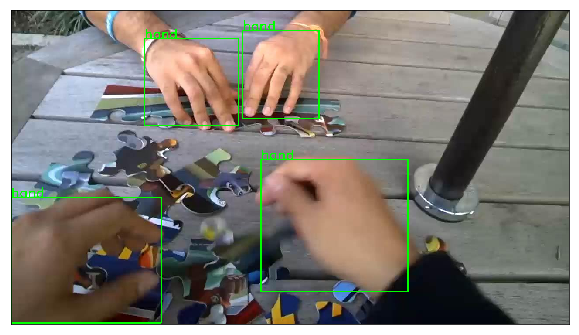

3


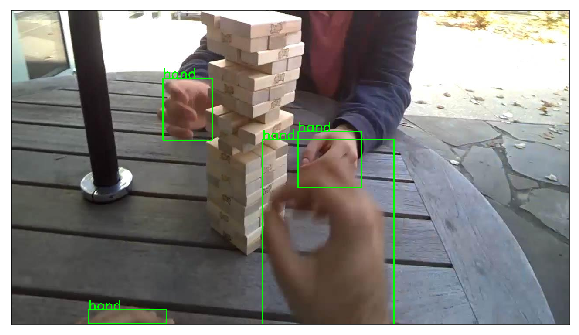

1


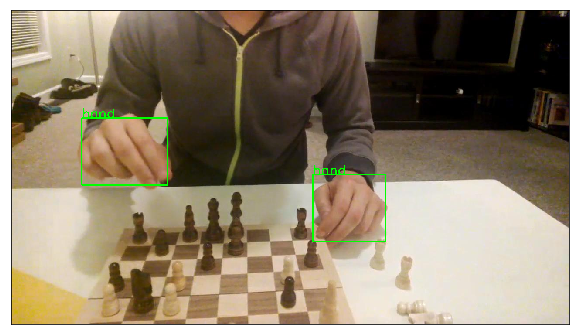

3


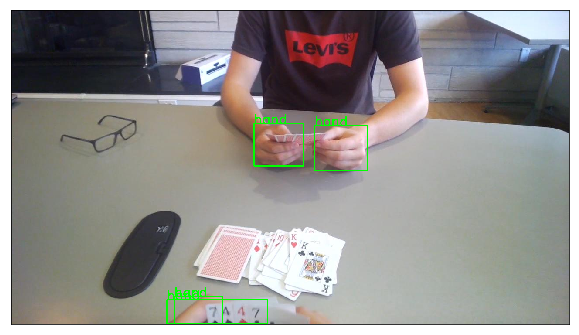

1


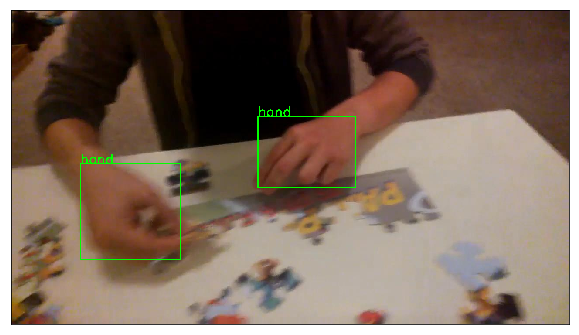

5


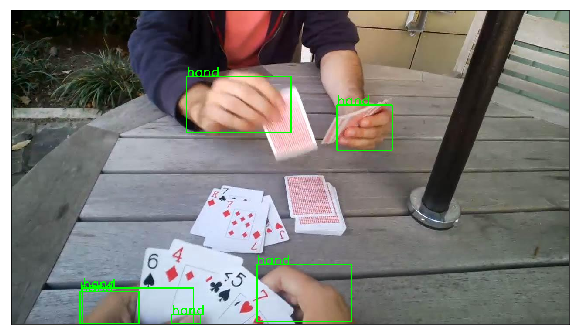

4


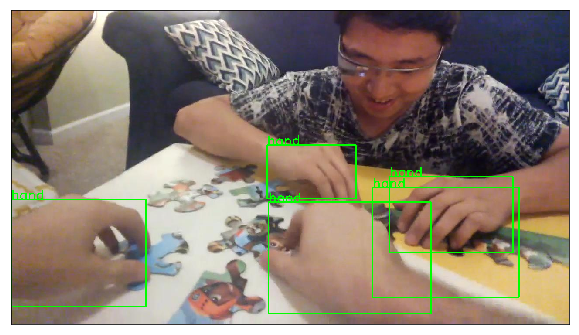

1


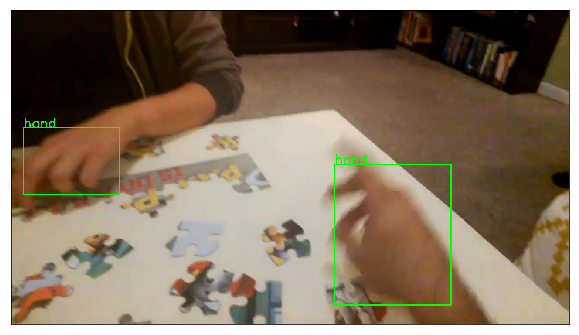

3


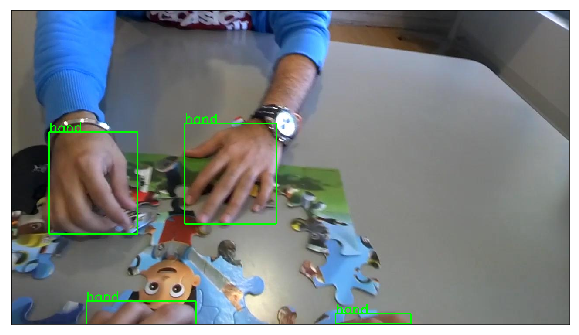

2


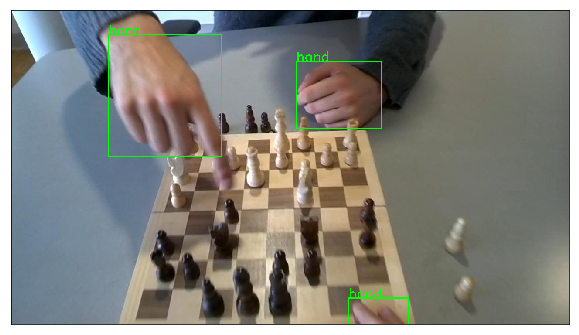

In [54]:
all_images = os.listdir("/scratch/sv1718/vision.soic.indiana.edu/egohands_files/DATA_IMAGES/")
random.shuffle(all_images)
for i in range(10):
    instance_segmentation_api("/scratch/sv1718/vision.soic.indiana.edu/egohands_files/DATA_IMAGES/"+all_images[i])